# 1a Neural Networks: Training and Optimization

You just joined the field robotics group as the new ML engineer. The rover team has a tiny computer and two noisy sensors that measure terrain features. The rover needs a small neural network to decide whether a patch of ground is safe to drive on. The model must be fast, simple, and reliable.

In this assignment you will build and train a **tiny 2-layer neural network** with NumPy. You will implement a few core pieces of backprop, add L2 regularization, and add dropout. The goal is not to memorize formulas, but to understand how the pieces fit together in a compact working example.

**What you will do**
- Inspect a small synthetic dataset that stands in for sensor readings.
- Complete three TODO blocks in the provided helper functions.
- Train the network and compare baseline vs. L2 vs. dropout.
- Answer two short written questions.


**Rules:**
- Use only NumPy.
- Do not import additional libraries.
- Keep your code in the provided functions.


## Learning goals and deliverables

By the end, you should be able to:
- Explain how a 2-layer network computes scores and how gradients flow backward.
- Add L2 regularization to both the loss and gradients.
- Use dropout during training and disable it during evaluation.

**Deliverables**
- Completed TODO blocks in the helper functions cell.
- Short written answers in the final section.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Toy binary classification dataset

def make_toy_data(n_per_class=100, seed=0):
    rng = np.random.RandomState(seed)
    X0 = rng.randn(n_per_class, 2) + np.array([-1.0, 0.0])
    X1 = rng.randn(n_per_class, 2) + np.array([1.0, 0.0])
    X = np.vstack([X0, X1])
    y = np.array([0] * n_per_class + [1] * n_per_class)
    idx = rng.permutation(len(y))
    return X[idx], y[idx]

X, y = make_toy_data(n_per_class=150, seed=0)

# Train/validation split
split = int(0.8 * len(y))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (240, 2) (240,)
Val: (60, 2) (60,)


### Visualization 1: Sensor space

The scatter plot below shows the two sensor readings for each example. Each point is a terrain patch. The colors show the class labels (safe vs. unsafe). Overlap between colors indicates that the classes are not perfectly separable, which is why we need a learned decision boundary.


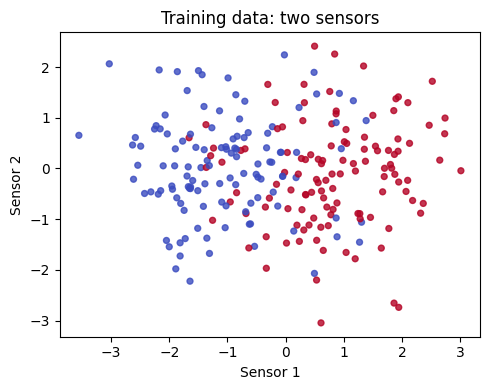

In [3]:
# Visualize the dataset

plt.figure(figsize=(5, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", s=18, alpha=0.8)
plt.title("Training data: two sensors")
plt.xlabel("Sensor 1")
plt.ylabel("Sensor 2")
plt.tight_layout()


### Dataset story and setup

The rover has **two sensors**, so each input has two numbers. The dataset contains two classes:
- Class 0: safe terrain
- Class 1: unsafe terrain

We use a tiny synthetic dataset so you can run everything quickly and focus on training mechanics rather than data loading. A train/validation split is provided for you. The scatter plot below shows the two sensor features and their class overlap.


## Part 1: Backprop TODOs

This section is the core learning task. You will complete three TODO blocks:
1. The ReLU backward mask (one line).
2. The dropout mask in the forward pass (a few lines).
3. The L2 regularization terms in the loss and gradients (a few lines).

Everything else is already written. The goal is to connect the math with the code, not to write a full network from scratch.


### Backprop cheat sheet (reference)

Use this as a quick reference while you fill the TODOs. Shapes shown in parentheses help you sanity-check your work.

Let:
- `X` be input data of shape `(N, D)`
- `W1` shape `(D, H)`, `b1` shape `(H,)`
- `W2` shape `(H, C)`, `b2` shape `(C,)`

Forward pass:
- `z1 = X @ W1 + b1`  -> shape `(N, H)`
- `h1 = ReLU(z1)`     -> shape `(N, H)`
- `scores = h1 @ W2 + b2` -> shape `(N, C)`

Backward pass (given `dscores` from softmax loss):
- `dW2 = h1.T @ dscores`
- `db2 = sum(dscores, axis=0)`
- `dh1 = dscores @ W2.T`
- `dz1 = dh1`, then set `dz1[z1 <= 0] = 0`
- `dW1 = X.T @ dz1`
- `db1 = sum(dz1, axis=0)`

L2 regularization:
- Add `0.5 * reg * (||W1||^2 + ||W2||^2)` to the loss
- Add `reg * W1` and `reg * W2` to `dW1`, `dW2`

Dropout (inverted dropout):
- During training: `mask = (rand >= p) / (1 - p)`
- Apply `h1 = h1 * mask` in forward and `dh1 = dh1 * mask` in backward
- During evaluation: no dropout (use the full activations)


In [ ]:
# Demo: ReLU mask and dropout (read-only)

z = np.array([[-1.0, 0.5], [2.0, -0.1]])
h = np.maximum(0.0, z)
relu_mask = (z > 0).astype(float)

print("z =", z)
print("ReLU(z) =", h)
print("ReLU mask =", relu_mask)

rng = np.random.RandomState(0)
p = 0.3
mask = (rng.rand(*h.shape) >= p) / (1.0 - p)
print("Dropout mask =", mask)
print("h after dropout =", h * mask)


In [ ]:
# Helper functions

def initialize_params(input_dim, hidden_dim, num_classes, seed=0):
    rng = np.random.RandomState(seed)
    params = {
        "W1": 0.01 * rng.randn(input_dim, hidden_dim),
        "b1": np.zeros(hidden_dim),
        "W2": 0.01 * rng.randn(hidden_dim, num_classes),
        "b2": np.zeros(num_classes),
    }
    return params


def softmax_loss(scores, y):
    shifted = scores - np.max(scores, axis=1, keepdims=True)
    exp_scores = np.exp(shifted)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    n = scores.shape[0]
    loss = -np.log(probs[np.arange(n), y]).mean()
    dscores = probs
    dscores[np.arange(n), y] -= 1
    dscores /= n
    return loss, dscores


def relu_backward(dout, z):
    # TODO: zero out gradients where z <= 0.
    # YOUR CODE HERE
    dout = dout.copy()
    dout[z <= 0] = 0
    return dout


def forward(X, params, dropout_prob=0.0, training=True, seed=None):
    # Compute scores for a 2-layer network.
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]

    z1 = X @ W1 + b1
    h1 = np.maximum(0.0, z1)

    mask = None
    # TODO: implement dropout for training only.
    # YOUR CODE HERE
    if training and dropout_prob > 0.0:
        rng = np.random.RandomState(seed)
        mask = (rng.rand(*h1.shape) >= dropout_prob) / (1.0 - dropout_prob)
        h1 *= mask
    else:
        mask = None

    scores = h1 @ W2 + b2
    cache = (X, z1, h1, mask)
    return scores, cache


def backward(dscores, cache, params, reg=0.0):
    # Backpropagate gradients for the 2-layer network.
    X, z1, h1, mask = cache
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]

    dW2 = h1.T @ dscores
    db2 = np.sum(dscores, axis=0)

    dh1 = dscores @ W2.T
    # TODO: apply dropout mask if it was used.
    # YOUR CODE HERE
    if mask is not None:
        dh1 *= mask
    else:
        pass
    dz1 = relu_backward(dh1, z1)

    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0)

    # TODO: add L2 gradients for W1 and W2.
    # YOUR CODE HERE
    dW1 += 2 * reg * W1
    dW2 += 2 * reg * W2

    grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
    return grads


def loss_and_grads(X, y, params, reg=0.0, dropout_prob=0.0, training=True, seed=None):
    # Compute softmax loss and gradients for the network.
    scores, cache = forward(X, params, dropout_prob=dropout_prob, training=training, seed=seed)
    loss, dscores = softmax_loss(scores, y)

    # TODO: add L2 loss for W1 and W2.
    # YOUR CODE HERE
    loss += reg * (np.sum(params["W1"] ** 2) + np.sum(params["W2"] ** 2))
    
    grads = backward(dscores, cache, params, reg=reg)
    return loss, grads


In [5]:
params = initialize_params(2, 4, 2, seed=0)
scores, cache = forward(X_train[:5], params, dropout_prob=0.0, training=True, seed=0)
assert scores.shape == (5, 2)


In [6]:
params = initialize_params(2, 5, 2, seed=1)
loss, grads = loss_and_grads(X_train[:10], y_train[:10], params, reg=0.1, dropout_prob=0.0, training=True, seed=1)
assert np.isfinite(loss)
for k in ["W1", "b1", "W2", "b2"]:
    assert grads[k].shape == params[k].shape


In [7]:
params = initialize_params(2, 8, 2, seed=2)
loss1, grads = loss_and_grads(X_train, y_train, params, reg=0.0, dropout_prob=0.0, training=True, seed=0)
for k in params:
    params[k] = params[k] - 0.05 * grads[k]
loss2, _ = loss_and_grads(X_train, y_train, params, reg=0.0, dropout_prob=0.0, training=True, seed=1)
assert loss2 < loss1


In [8]:
params = initialize_params(2, 4, 2, seed=3)
scores_train, _ = forward(X_train[:6], params, dropout_prob=0.5, training=True, seed=0)
scores_eval, _ = forward(X_train[:6], params, dropout_prob=0.5, training=False, seed=0)
scores_eval_ref, _ = forward(X_train[:6], params, dropout_prob=0.0, training=False, seed=0)
assert np.allclose(scores_eval, scores_eval_ref)


## Part 2: Training loop and evaluation

The training loop is provided. It runs simple gradient descent for a fixed number of epochs. Run the baseline training once and record:
- Final training accuracy
- Final validation accuracy
- Final loss

These numbers will serve as your baseline when you add regularization and dropout later.


In [9]:
# Training utilities

def predict(X, params):
    scores, _ = forward(X, params, dropout_prob=0.0, training=False, seed=0)
    return np.argmax(scores, axis=1)


def accuracy(X, y, params):
    preds = predict(X, params)
    return np.mean(preds == y)


def train(X, y, params, lr=0.1, reg=0.0, dropout_prob=0.0, epochs=200, seed=0):
    losses = []
    for t in range(epochs):
        loss, grads = loss_and_grads(
            X, y, params, reg=reg, dropout_prob=dropout_prob, training=True, seed=seed + t
        )
        for k in params:
            params[k] -= lr * grads[k]
        losses.append(loss)
    return losses, params


In [10]:
# Baseline training
params = initialize_params(2, 16, 2, seed=0)
losses, params = train(X_train, y_train, params, lr=0.2, reg=0.0, dropout_prob=0.0, epochs=200, seed=0)

print("Final train acc:", accuracy(X_train, y_train, params))
print("Final val acc:", accuracy(X_val, y_val, params))
print("Final loss:", losses[-1])


Final train acc: 0.8416666666666667
Final val acc: 0.7833333333333333
Final loss: 0.3999532250015001


### Visualization 2: Training loss curve

This plot shows how the loss changes over training epochs. A downward trend indicates that gradient descent is improving the model. If the curve is flat or unstable, the learning rate may be too low or too high.


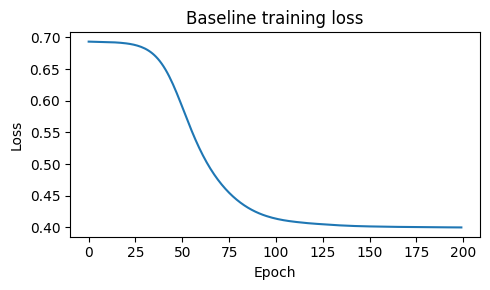

In [11]:
# Plot the training loss curve

plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.title("Baseline training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()


## Part 3: Regularization and dropout

The rover team wants the model to **generalize**: good validation accuracy matters more than perfect training accuracy.

You will run two small experiments:
1. **L2 regularization**: adds a penalty for large weights, which often reduces overfitting.
2. **Dropout**: randomly drops hidden units during training so the network does not rely on any single feature.

Run the provided cells and compare train vs. validation accuracy. You are not expected to tune hyperparameters; just observe the effect.


In [12]:
# L2 regularization
params_reg = initialize_params(2, 16, 2, seed=0)
losses_reg, params_reg = train(X_train, y_train, params_reg, lr=0.2, reg=0.1, dropout_prob=0.0, epochs=200, seed=0)

print("L2 train acc:", accuracy(X_train, y_train, params_reg))
print("L2 val acc:", accuracy(X_val, y_val, params_reg))
print("L2 final loss:", losses_reg[-1])


L2 train acc: 0.8291666666666667
L2 val acc: 0.8166666666666667
L2 final loss: 0.5779012379421933


In [13]:
# Dropout
params_drop = initialize_params(2, 16, 2, seed=0)
losses_drop, params_drop = train(X_train, y_train, params_drop, lr=0.2, reg=0.0, dropout_prob=0.3, epochs=200, seed=0)

print("Dropout train acc:", accuracy(X_train, y_train, params_drop))
print("Dropout val acc:", accuracy(X_val, y_val, params_drop))
print("Dropout final loss:", losses_drop[-1])


Dropout train acc: 0.8333333333333334
Dropout val acc: 0.8
Dropout final loss: 0.4156442514328793


## Part 4: Short written answers (not graded)

Write your answers below. These questions are not graded, only for practice.

1. **L2 regularization effect:** What happened to training loss and validation accuracy compared to baseline?
2. **Dropout at evaluation:** Why must dropout be disabled when you evaluate on validation data?
